# Description

Somewhat cleaner notebook for exploring learning IVs, in the linear case.

# Imports

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import pandas as pd
import seaborn as sns

from ipywidgets import interact_manual, IntSlider, FloatSlider
from sklearn.linear_model import LinearRegression
from linearmodels.iv.model import IV2SLS

%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm

In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression

from econml.grf import RegressionForest

# Setup: linear treatment effects

We take a classic linear regression setup, where the treatment is correlated with some confounder $C$:

$$
Y = \beta + \tau T + \gamma C + \epsilon, \;\; Cov(T,C) \neq 0
$$

The estimand of interest is $\tau$, the treatment effect.

We then have an instrumental variable $Z$ such that:

$$
T = \pi Z + \psi C + \eta, \;\; Cov(Z,C) = 0
$$

In [4]:
def generate_const_linear_iv(
    n_samples,
    seed,
    pi,
    psi,
    tau,
    gamma
):
    """
    Generates linear IV with constant treatment effects.
    
    Args:
        n_samples (int): num samples to generate
        seed (int): seed for reproducibilty
        pi (float): instrument "strength"
        psi (float): confounding "strength"
        tau (float): treatment effect
        gamma (float): confound effect
    
    Returns:
        pd.DataFrame
    """
    np.random.seed(seed),
    Z = np.random.normal(0, 1, size=n_samples)#np.random.uniform(0, 10, n_samples)
    C = np.random.normal(0, 1, size=n_samples)#np.random.uniform(0, 10, n_samples)
    eta = np.random.normal(0, 1, size=n_samples)
    const = np.random.uniform(-1, 1)

    T = const + (pi*Z) + (psi*C) + eta

    epsilon = np.random.normal(0, 1, size=n_samples)
    beta = np.random.uniform(-1, 1)

    Y = beta + (tau*T) + (gamma*C) + epsilon

    data = np.concatenate([Z.reshape(-1,1), 
                           C.reshape(-1,1), 
                           T.reshape(-1,1),
                           Y.reshape(-1,1),], 
                         axis=1)

    data_df = pd.DataFrame(data, columns=['Z', 'C', 'T', 'Y'])

    return data_df


## Validation

In [5]:
# generate IV data

# consts
n_samples = 1000
seed = 42
pi = 1 # IV "strength"
psi = 5 # confound "strength"

tau = 2 # treat effect
gamma = -5 # confound effect

df = generate_const_linear_iv(
        n_samples,
        seed,
        pi,
        psi,
        tau,
        gamma)

df

Z         C         T         Y
0    0.496714  1.399355  7.455794  8.165450
1   -0.138264  0.924634  4.977866  6.099834
2    0.647689  0.059630  0.790901  1.169550
3    1.523030 -0.646937 -1.382135  0.640969
4   -0.234153  0.698223  2.000829  0.956657
..        ...       ...       ...       ...
995 -0.281100  1.070150  5.784612  6.625270
996  1.797687 -0.026521  2.560313  5.047941
997  0.640843 -0.881875 -4.372811 -3.512755
998 -0.571179 -0.163067 -0.414857  0.175355
999  0.572583 -0.744903 -2.669709 -2.124274

[1000 rows x 4 columns]

(-10.0, 10.0)

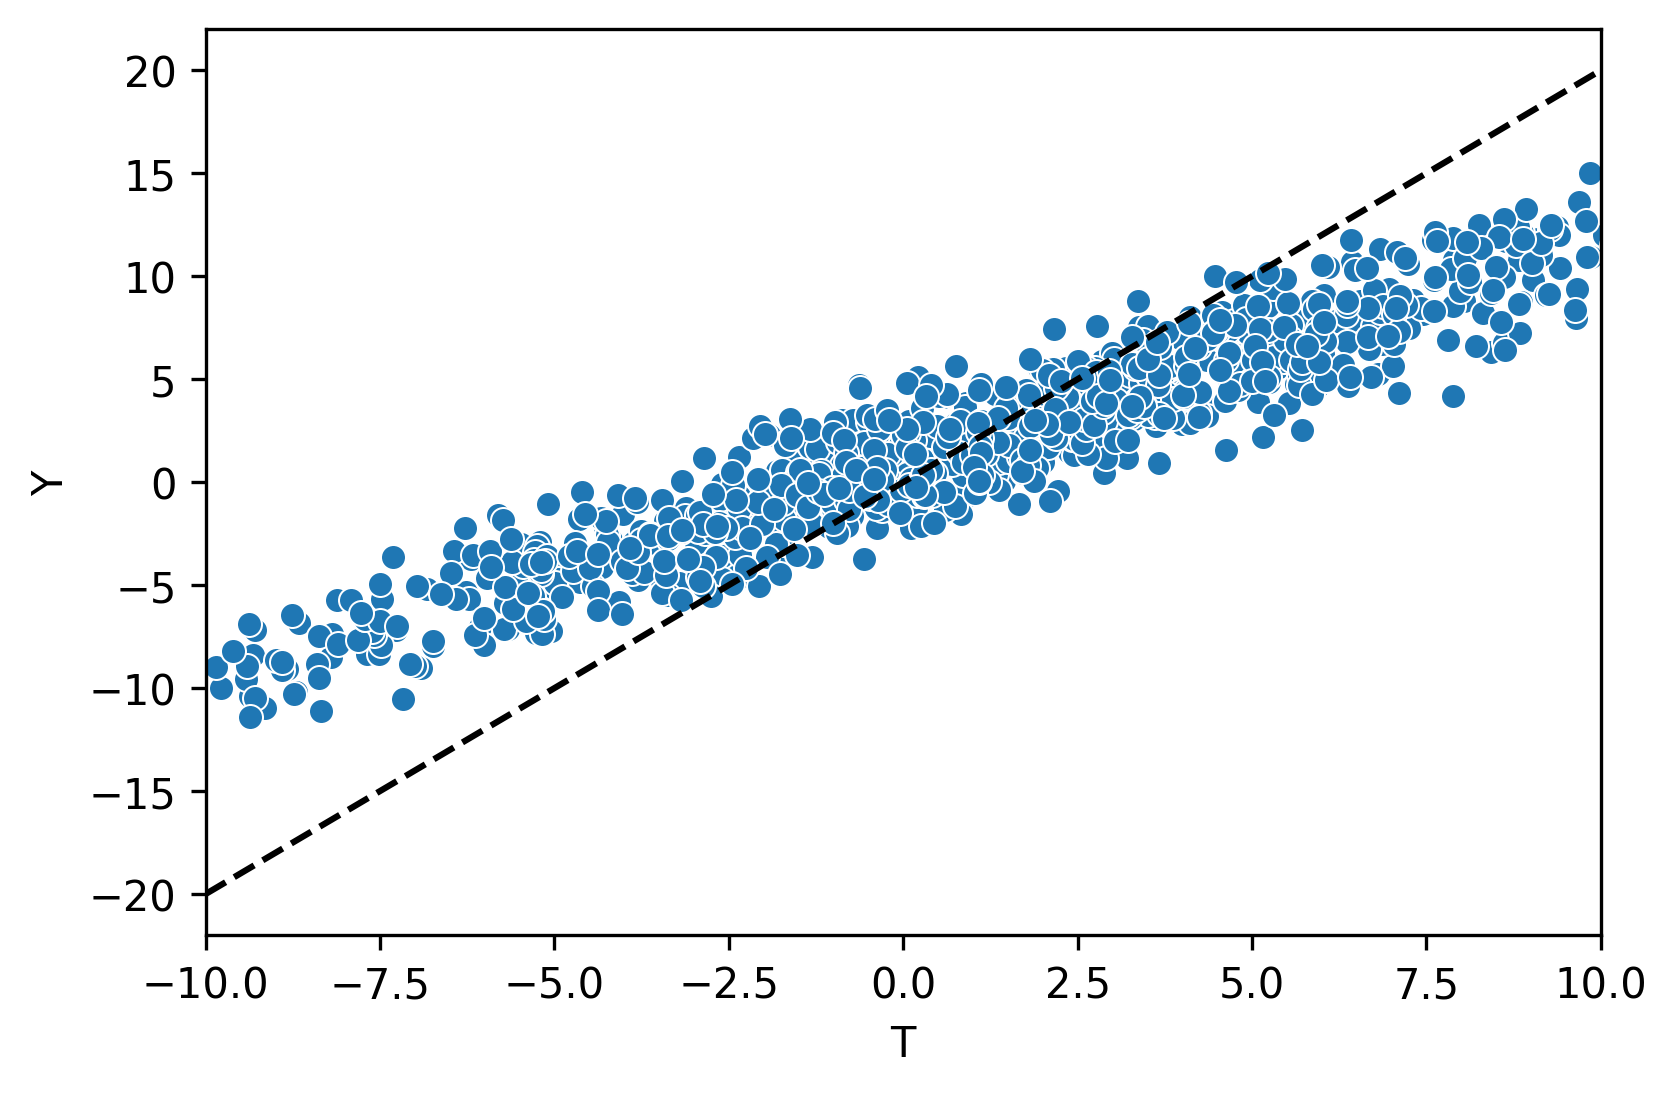

In [6]:
fig, ax = plt.subplots()

ax.plot(np.linspace(-10,10, 20), 2*np.linspace(-10,10,20), ls='--', color='black')
sns.scatterplot(x='T', y='Y', data=df, ax=ax)
ax.set_xlim(-10,10)

In [7]:
feat_cols = [
    "mean_Z",
    "mean_T",
    "mean_Y",
    "var_Z",
    "var_T",
    "var_Y",
    "cov_ZT",
    "cov_ZY",
    "cov_TY",
    "n"
]

def generate_iv_features(data_df, confounder='C'):
    """Generates IV features from a given simple (four variable) data matrix."""
    
    data = data_df.drop(confounder, axis='columns', errors='ignore')   
    data = data[["Z", "T", "Y"]]
    
    cov_mat = np.cov(data, rowvar=False)

    var = np.diag(cov_mat).reshape(-1)
    var = var[var != 0]
    
    cov = np.array([cov_mat[0,1], cov_mat[0,2], cov_mat[1,2]])
    mean = np.mean(data).values

    feats = np.concatenate([mean, var, cov, np.array(data_df.shape[0]).reshape(-1)])

    return pd.DataFrame(feats.reshape(1, -1), columns=feat_cols)

In [8]:
feat_df = generate_iv_features(df)

## Full simulations: varying IV strength

### Regression, TSLS 

In [9]:
iv_strs = np.round(np.linspace(.2, 2, 10), 2) #np.round(np.linspace(0.1, 0.9, 9), 2)
n_datasets = 10000
n_test_datasets = 2000

#n_samples = 1000
psi = 5 # confound "strength"

iv_mses = []
reg_mses = []

iv_stderrs = []
iv_preds = []
reg_preds = []

for pi in tqdm(iv_strs):
    print(pi)
    lin_reg_taus = np.zeros(n_test_datasets)
    tsls_taus = np.zeros(n_test_datasets)
    tsls_stderrs = np.zeros(n_test_datasets)
    test_taus = np.zeros(n_test_datasets)

    for i in range(n_test_datasets):
        seed = i + int(pi*10000) # to ensure we have non-overlapping datasets
        
        treat_effect = np.random.uniform(-2, 2)
        confound_effect = np.random.uniform(1, 5)
        n_samples = 1000
        #n_samples = int(np.random.uniform(500, 5000))
        
        data_df = generate_const_linear_iv(
            n_samples=n_samples,
            seed=seed,
            pi=pi,
            psi=psi,
            tau=treat_effect,
            gamma=confound_effect)
        
        lin_reg = LinearRegression()

        lin_reg.fit(data_df['T'].values.reshape(-1,1), data_df['Y'])
        tsls = IV2SLS.from_formula('Y ~ 1 + [T ~ Z]',
                                   data=data_df)    
        iv_res = tsls.fit()
        
        lin_reg_taus[i] = lin_reg.coef_[0]
        tsls_taus[i] = iv_res.params['T']
        tsls_stderrs[i] = iv_res.std_errors['T']

        test_taus[i] = treat_effect
        #break
    iv_preds.append(tsls_taus)
    iv_stderrs.append(tsls_stderrs)
    reg_preds.append(lin_reg_taus)
        
    iv_mses.append(mse(tsls_taus, test_taus))
    reg_mses.append(mse(lin_reg_taus, test_taus))
    #break

  0%|          | 0/10 [00:00<?, ?it/s]

0.2


 10%|█         | 1/10 [00:19<02:56, 19.65s/it]

0.4


 20%|██        | 2/10 [00:39<02:37, 19.66s/it]

0.6


 30%|███       | 3/10 [00:58<02:17, 19.66s/it]

0.8


 40%|████      | 4/10 [01:18<01:57, 19.66s/it]

1.0


 50%|█████     | 5/10 [01:38<01:38, 19.63s/it]

1.2


 60%|██████    | 6/10 [01:57<01:18, 19.65s/it]

1.4


 70%|███████   | 7/10 [02:17<00:58, 19.66s/it]

1.6


 80%|████████  | 8/10 [02:37<00:39, 19.66s/it]

1.8


 90%|█████████ | 9/10 [02:56<00:19, 19.63s/it]

2.0


100%|██████████| 10/10 [03:16<00:00, 19.65s/it]


In [10]:
reg_mses

[0.38197769801530357,
 0.37699140178044,
 0.37124062438348715,
 0.3617092357135151,
 0.35944525264113375,
 0.3339468130476066,
 0.3250928725025491,
 0.31696905059952346,
 0.2998518794039199,
 0.28901504230713193]

In [11]:
iv_mses

[48.989658229583455,
 15.505046816571557,
 3.4484049564709243,
 0.027546577311709064,
 0.015214074210619351,
 0.009640863985447189,
 0.006727351601334576,
 0.004460753894411381,
 0.003558966233166242,
 0.0029926692099676443]

### Features for supervised learning

In [12]:
ml_mses = []
ml_preds = []

wald_preds = []
wald_mses = []

test_taus = []
test_feats = []
test_stderrs = []
feat_importances = []

n_datasets = 10000
n_test_datasets = 2000

for pi in tqdm(iv_strs):
    data = np.zeros((n_datasets, 10))
    taus = np.zeros(n_datasets)
    confounds = np.zeros(n_datasets)
    
    for i in range(n_datasets):
        seed = i + int(pi*10000) # to ensure we have non-overlapping datasets
        
        treat_effect = np.random.uniform(-2, 2)
        confound_effect = np.random.uniform(1, 5)
        n_samples = 1000
        
        data_df = generate_const_linear_iv(
            n_samples=n_samples,
            seed=seed,
            pi=pi,
            psi=psi,
            tau=treat_effect,
            gamma=confound_effect)
        
        feats = generate_iv_features(data_df)
        data[i,:] = feats
        taus[i] = treat_effect
        confounds[i] = confound_effect
        
    X_train = data[n_test_datasets:, :]
    X_test = data[:n_test_datasets, :]

    y_train = taus[n_test_datasets:]
    y_test = taus[:n_test_datasets]
    
    meta_learner = RegressionForest(random_state=42, n_estimators=100)
    meta_learner.fit(X_train, y_train)
    
    preds = meta_learner.predict(X_test)
    std_err = meta_learner.prediction_stderr(X_test)
    
    #        Cov(Z,Y)       Cov(T,Z)
    wald = X_test[:, 7] / X_test[:, 6]
    wald_preds.append(wald)
    
    ml_preds.append(preds)
    test_taus.append(y_test)
    test_feats.append(X_test)
    test_stderrs.append(std_err)
    
    feat_importances.append(meta_learner.feature_importances_)
    ml_mses.append(mse(preds, y_test))
    wald_mses.append(mse(wald, y_test))

100%|██████████| 10/10 [03:20<00:00, 20.05s/it]


In [13]:
ml_mses

[0.03309168096448562,
 0.018142551911855095,
 0.011282384564577653,
 0.006752249031976072,
 0.005124650704095621,
 0.00394418337301475,
 0.0030095091303020834,
 0.0024862325480178326,
 0.001834368102474821,
 0.0015361626840749362]

In [14]:
wald_mses

[48.98939785261783,
 15.505050478943927,
 3.4483596697094843,
 0.027543145011418125,
 0.015210915972150626,
 0.009640709838164266,
 0.0067264569682193584,
 0.004461078693961639,
 0.0035592040558897714,
 0.0029926634758771524]

(4, 3)


Text(0.5, 0.98, 'Covariance plots against estimated tau for IV str 2.0')

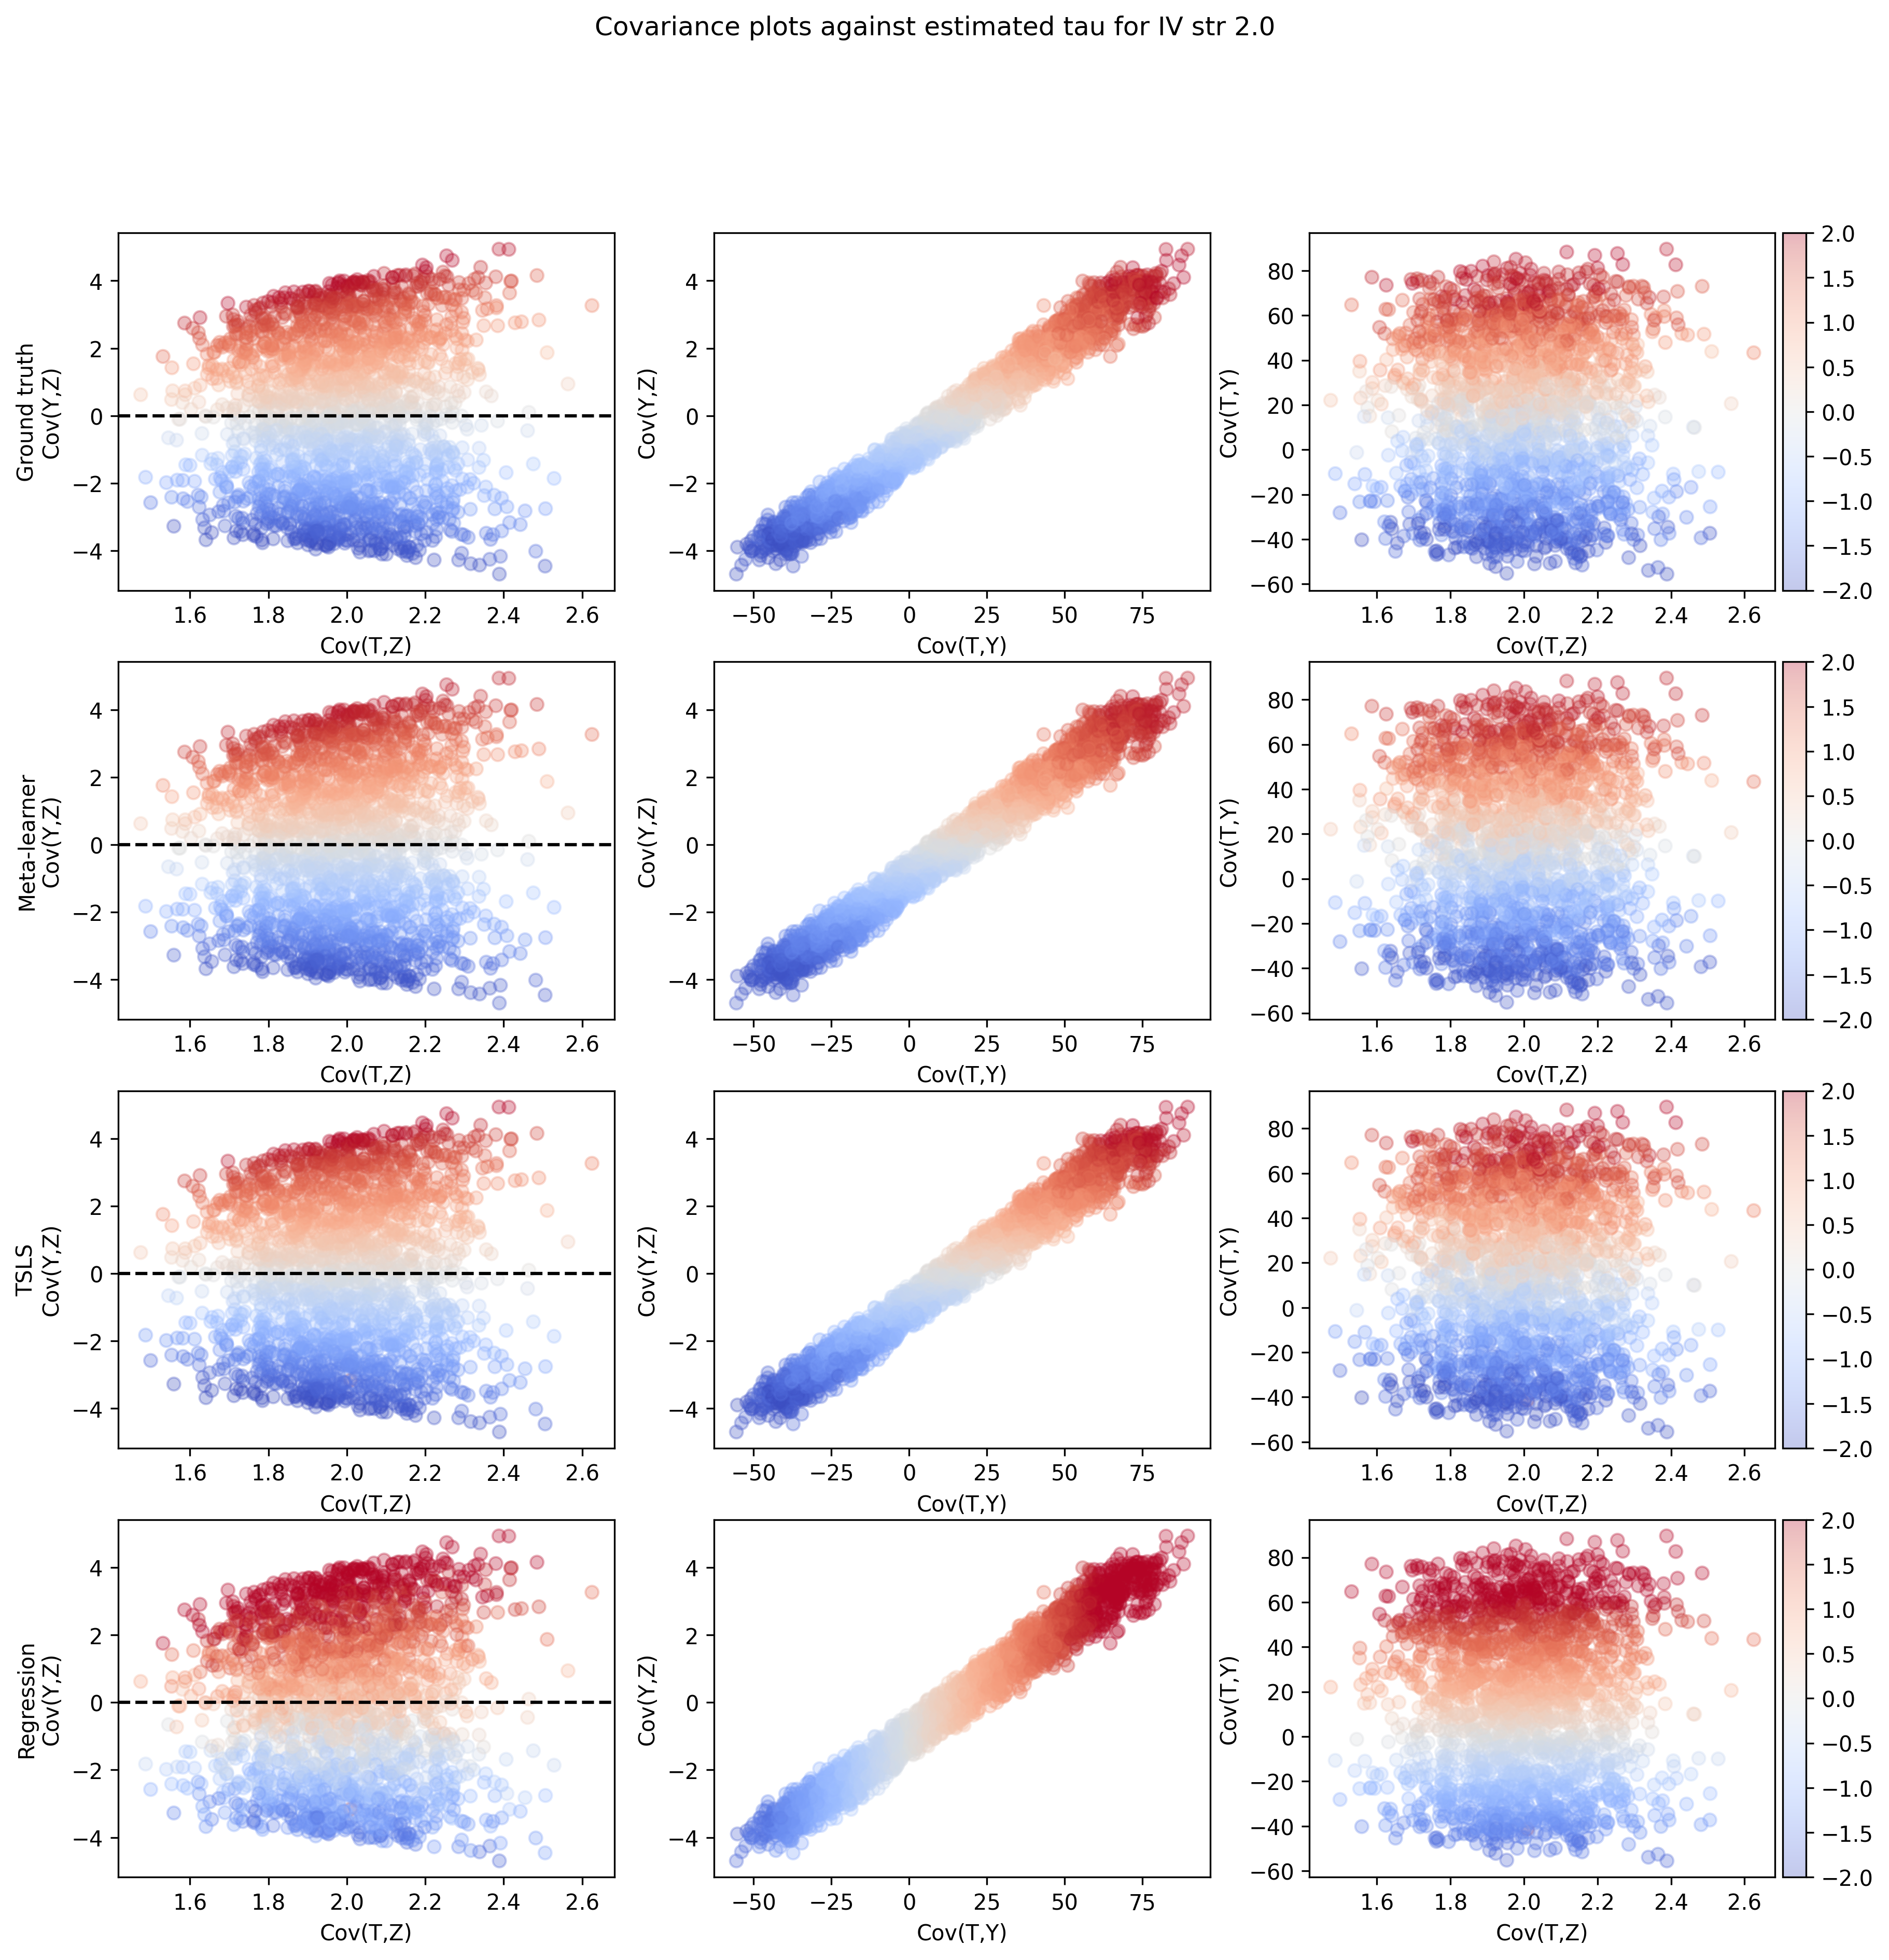

In [15]:
fig, axs = plt.subplots(4, 3, figsize=(14, 14), dpi=300)
fig.patch.set_color("white")
print(axs.shape)

COV_TY = 8
COV_YZ = 7
COV_TZ = 6

idx = -1

X_test = test_feats[idx]

# ground truth
ax1, ax2, ax3 = axs[0]
y = test_taus[idx]
sc = ax1.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax1.set_xlabel("Cov(T,Z)")
ax1.set_ylabel("Ground truth\nCov(Y,Z)")
sc = ax2.scatter(x=X_test[:,COV_TY], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax2.set_xlabel("Cov(T,Y)")
ax2.set_ylabel("Cov(Y,Z)")
sc = ax3.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_TY], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax3.set_xlabel("Cov(T,Z)")
ax3.set_ylabel("Cov(T,Y)")
ax1.axhline(y=0, ls='--', color='black')

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sc, cax=cax, orientation='vertical')

# ml
ax1, ax2, ax3 = axs[1]
y = ml_preds[idx]
sc = ax1.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax1.set_xlabel("Cov(T,Z)")
ax1.set_ylabel("Meta-learner\nCov(Y,Z)")
sc = ax2.scatter(x=X_test[:,COV_TY], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax2.set_xlabel("Cov(T,Y)")
ax2.set_ylabel("Cov(Y,Z)")
sc = ax3.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_TY], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax3.set_xlabel("Cov(T,Z)")
ax3.set_ylabel("Cov(T,Y)")
ax1.axhline(y=0, ls='--', color='black')

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sc, cax=cax, orientation='vertical')

# tsls
ax1, ax2, ax3 = axs[2]
y = iv_preds[idx]
sc = ax1.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax1.set_xlabel("Cov(T,Z)")
ax1.set_ylabel("TSLS\nCov(Y,Z)")
sc = ax2.scatter(x=X_test[:,COV_TY], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax2.set_xlabel("Cov(T,Y)")
ax2.set_ylabel("Cov(Y,Z)")
sc = ax3.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_TY], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax3.set_xlabel("Cov(T,Z)")
ax3.set_ylabel("Cov(T,Y)")
ax1.axhline(y=0, ls='--', color='black')

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sc, cax=cax, orientation='vertical')

# reg
ax1, ax2, ax3 = axs[3]
y = reg_preds[idx]
sc = ax1.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax1.set_xlabel("Cov(T,Z)")
ax1.set_ylabel("Regression\nCov(Y,Z)")
sc = ax2.scatter(x=X_test[:,COV_TY], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax2.set_xlabel("Cov(T,Y)")
ax2.set_ylabel("Cov(Y,Z)")
sc = ax3.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_TY], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax3.set_xlabel("Cov(T,Z)")
ax3.set_ylabel("Cov(T,Y)")

ax1.axhline(y=0, ls='--', color='black')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sc, cax=cax, orientation='vertical')
plt.suptitle("Covariance plots against estimated tau for IV str {}".format(iv_strs[idx]))

Text(0.5, 1.0, 'MSE for n=2000, confounded treatment, 10k datasets')

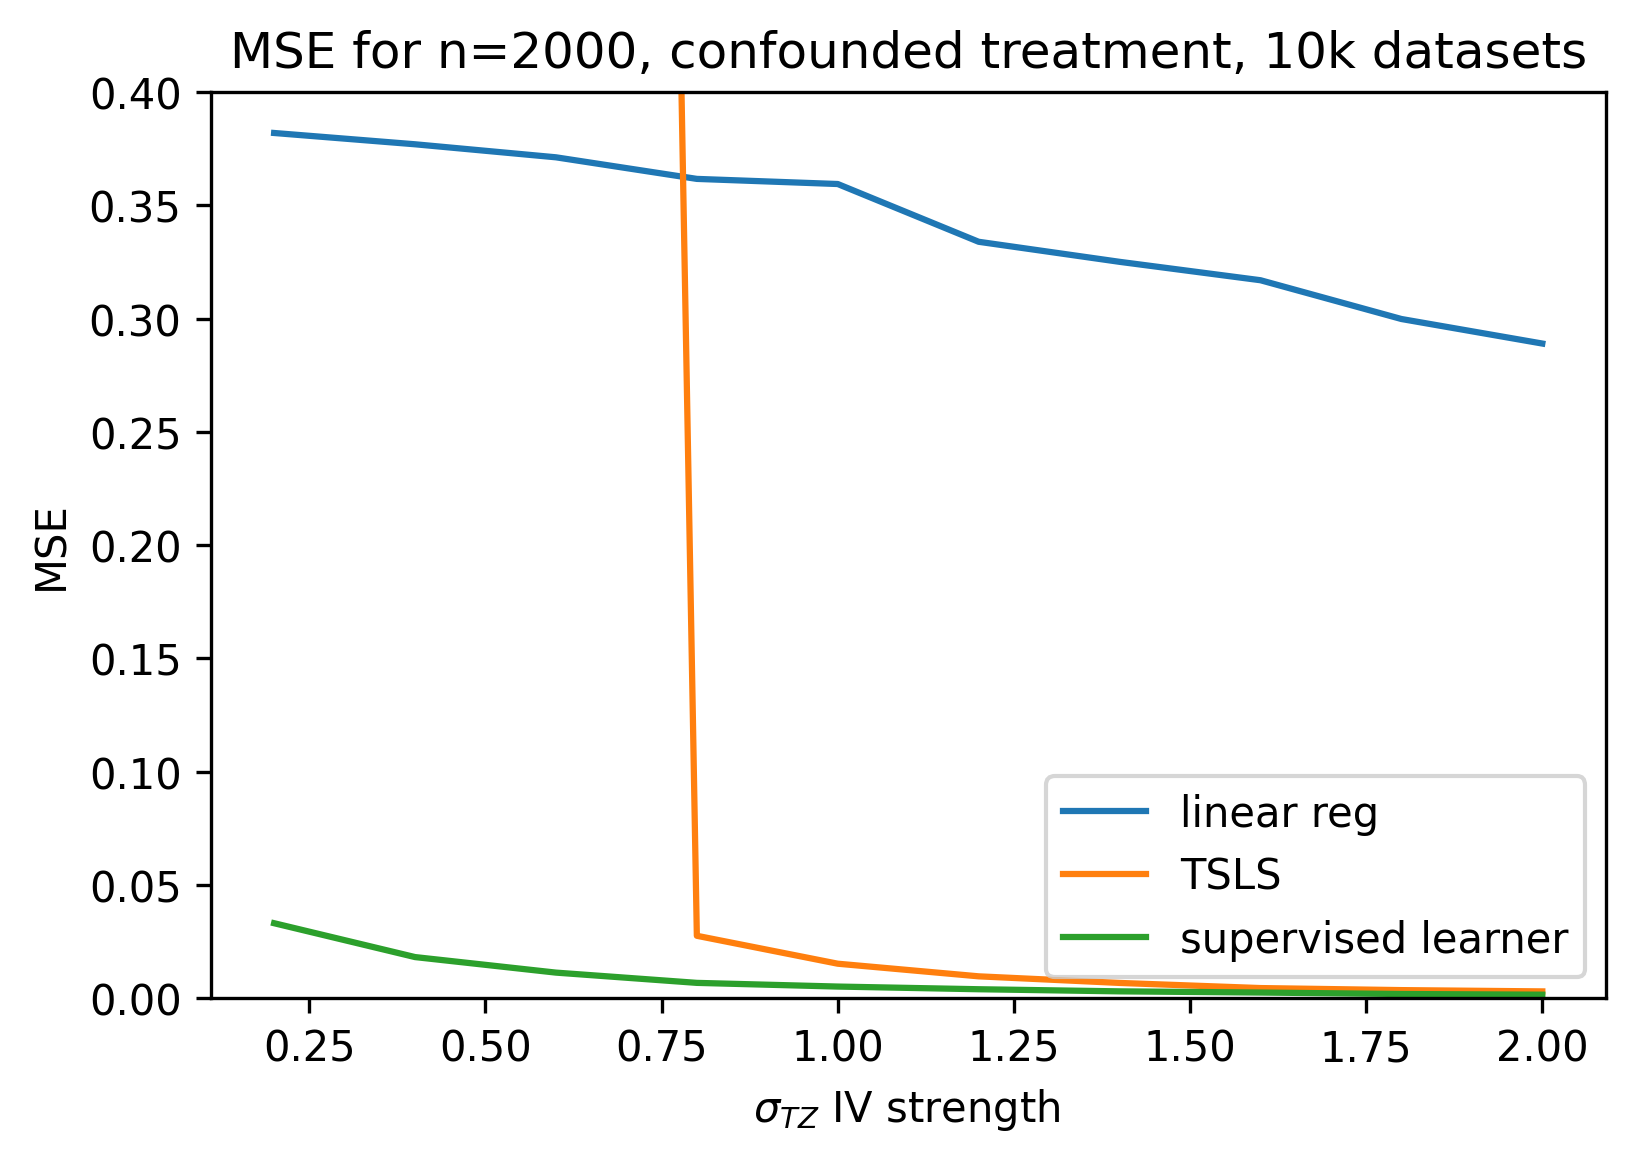

In [18]:
fig, ax = plt.subplots(dpi=300)
fig.patch.set_color("white")

ax.plot(iv_strs, reg_mses, label="linear reg")
ax.plot(iv_strs, iv_mses, label="TSLS")
ax.plot(iv_strs, ml_mses, label="supervised learner")
#ax.plot(iv_strs, wald_mses, label="Cov(Y,Z) / Cov(T,Z)")
ax.legend()
ax.set_ylim(0, 0.4)
ax.set_ylabel("MSE")
ax.set_xlabel("$\sigma_{TZ}$ IV strength ")
ax.set_title("MSE for n=2000, confounded treatment, 10k datasets")

Text(0.5, 1.0, 'Feature importances for n=1000, confounded treatment, 10k datasets')

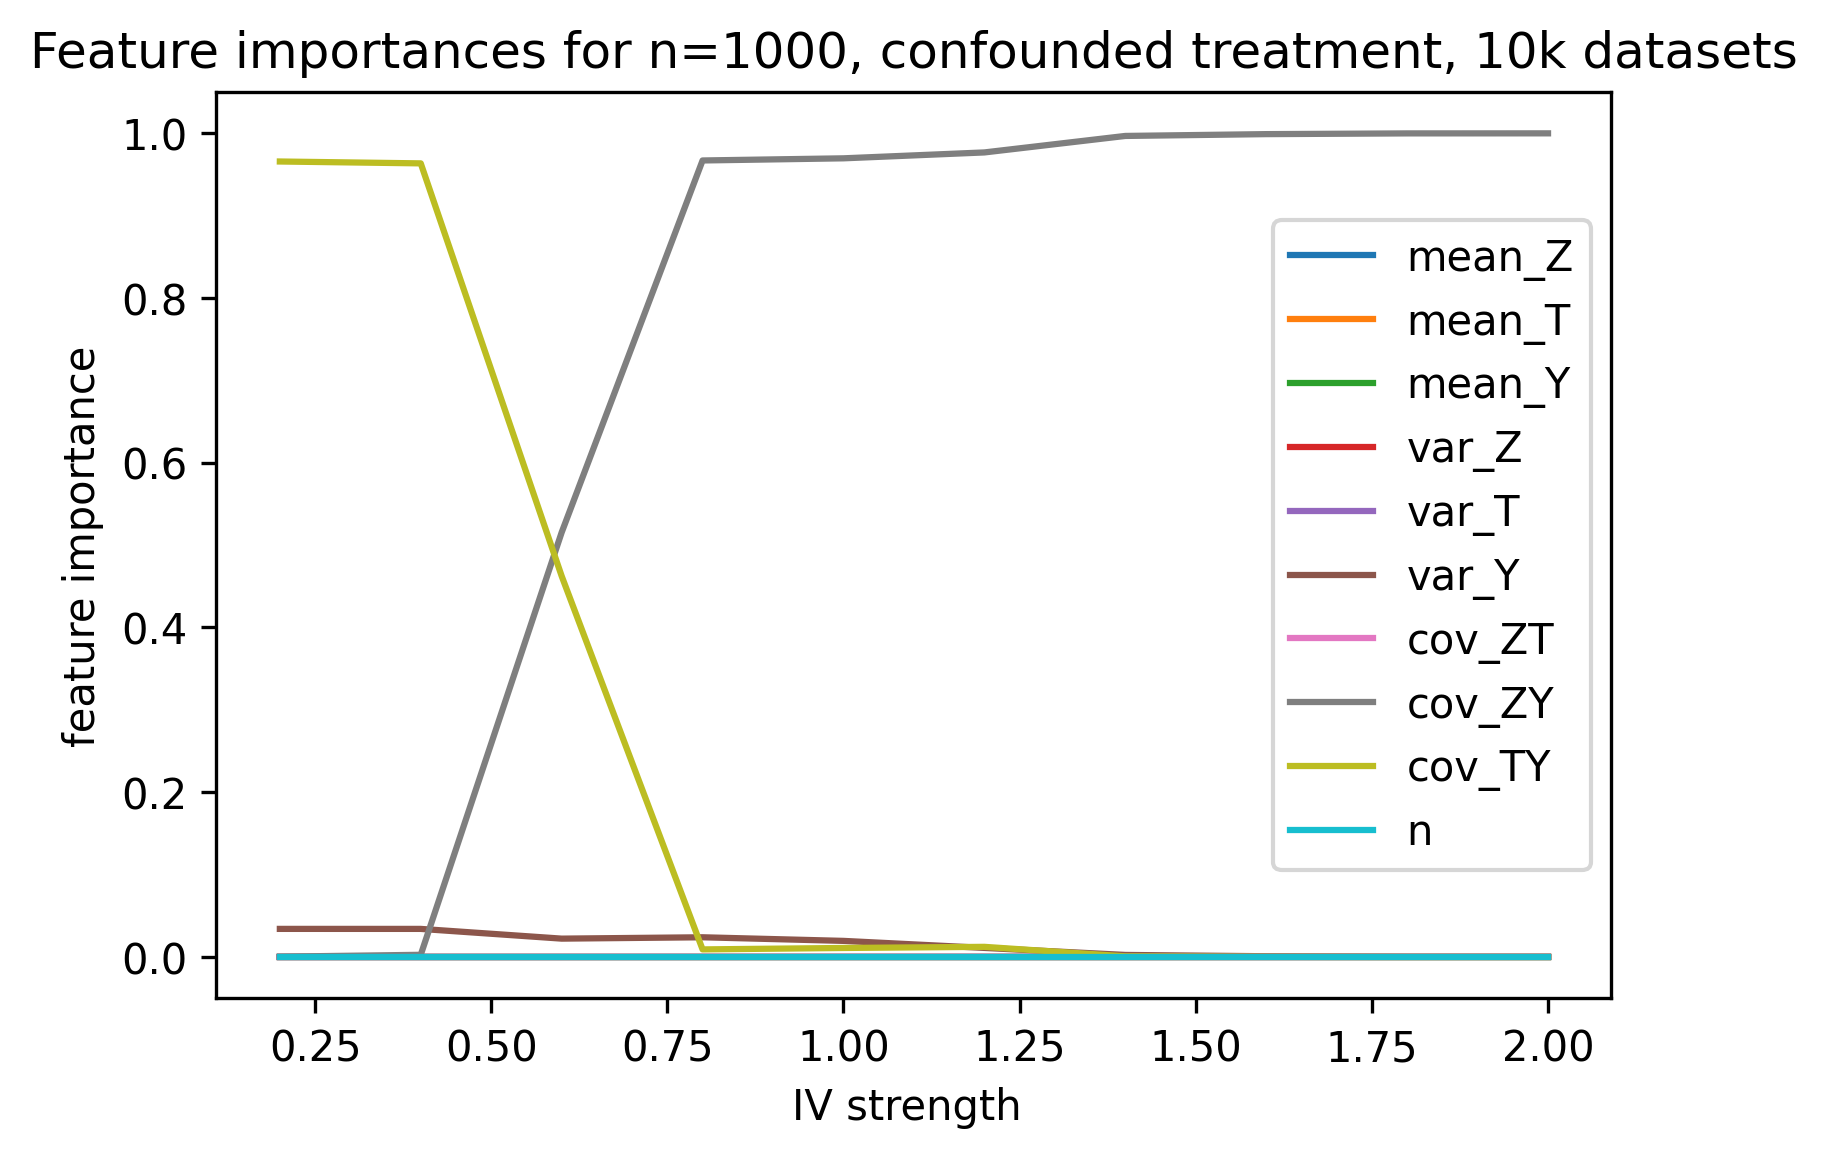

In [19]:
fig, ax = plt.subplots(dpi=300)
fig.patch.set_color("white")

# init into ndarray due to differences between econml and sklearn
feat_imp_array = np.array(feat_importances)

for i in range(10):
    ax.plot(iv_strs, feat_imp_array[:, i], label=feat_cols[i])
ax.legend()
#ax.set_ylim(0, 1)
ax.set_ylabel("feature importance")
ax.set_xlabel("IV strength ")
ax.set_title("Feature importances for n=1000, confounded treatment, 10k datasets")

## Test on flu data

In [20]:
%%time
data = np.zeros((n_datasets, 10))
taus = np.zeros(n_datasets)
confounds = np.zeros(n_datasets)

pi = 0.5

for i in tqdm(range(n_datasets)):
    seed = i + int(pi*10000) # to ensure we have non-overlapping datasets

    treat_effect = np.random.uniform(-2, 2)
    confound_effect = np.random.uniform(1, 5)
    n_samples = int(np.random.uniform(500, 5000))
    pi = np.random.uniform(0, 2)
    #n_samples = 1000

    data_df = generate_const_linear_iv(
        n_samples=n_samples,
        seed=seed,
        pi=pi,
        psi=psi,
        tau=treat_effect,
        gamma=confound_effect)

    feats = generate_iv_features(data_df)
    data[i,:] = feats
    taus[i] = treat_effect
    confounds[i] = confound_effect

X_train = data[n_test_datasets:, :]
X_test = data[:n_test_datasets, :]

y_train = taus[n_test_datasets:]
y_test = taus[:n_test_datasets]



100%|██████████| 10000/10000 [00:23<00:00, 427.40it/s]

CPU times: user 23.5 s, sys: 90.8 ms, total: 23.5 s
Wall time: 23.4 s


In [21]:
%%time
meta_learner = RegressionForest(random_state=42, n_estimators=100)
meta_learner.fit(X_train, y_train)
preds = meta_learner.predict(X_test)

mse(preds, y_test)

CPU times: user 4.47 s, sys: 23.2 ms, total: 4.5 s
Wall time: 501 ms


0.022860462514296645

In [22]:
flu_df = pd.read_stata("../datasets/flu/flu_clean.dta")

In [23]:
flu_df.head()

assign  receive  outcome  age  copd  dm  heartd  white  renal  female  \
0       1        1        0   73     0   1       1      1      0       1   
1       0        1        0   65     0   1       0      1      0       1   
2       0        1        0   77     1   1       1      1      0       1   
3       1        1        0   68     0   1       1      1      0       0   
4       1        0        1   68     0   1       1      1      0       1   

   liverd  comp  
0       0   1.0  
1       0   0.0  
2       0   0.0  
3       0   1.0  
4       0   0.0

In [24]:
sel_df = flu_df[flu_df['female'] == 1][['assign', 'receive', 'outcome']]
#sel_df = flu_df[['assign', 'receive', 'outcome']]

In [25]:
sel_df = sel_df.rename({
    'assign': 'Z',
    'receive': 'T',
    'outcome': 'Y'
}, axis='columns')

In [26]:
flu_feats = generate_iv_features(sel_df)

In [27]:
flu_feats

mean_Z    mean_T    mean_Y     var_Z     var_T     var_Y    cov_ZT  \
0  0.526151  0.237971  0.077406  0.249447  0.181436  0.071452  0.026479   

     cov_ZY    cov_TY       n  
0 -0.007258 -0.000638  1912.0

In [28]:
meta_learner.predict(flu_feats)

array([[-0.32376343]])

In [29]:
meta_learner.predict_interval(flu_feats)

(array([[-0.40059386]]), array([[-0.24693299]]))

In [30]:
meta_learner.prediction_stderr(flu_feats)

array([[0.03919992]])

# Setup: LATE

**TODO**